In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

We will be using [this dataset](https://www.kaggle.com/datasets/roudranildas/chicken-images-classification-dataset) from Kaggle.

This dataset has some subtilities too.

* Some of its images are just cartoons or even signs of a duck or a chicken. We intend to only classify the image of an actual duck or a chicken.
* Also, there are a lot number of images in this dataset. For explaining fine-tuning a pre-trained model, we have manually selected 109 images for each class (Duck or Chicken). Also, the testing dataset is also created in this manner, selecting 25 images for each class

We are going to fine-tune a pre-trained ResNet18 model for this task.

### Loading the dataset

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: (1-i) for i, cls in enumerate(self.classes)} # 0 for Duck, 1 for chicken
        self.images = []
        for cls in self.classes:
            class_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(class_dir):
                self.images.append((os.path.join(class_dir, img_name), self.class_to_idx[cls]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

### Making the custom transform for image pre-processing

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

The datasets have been saved on google drive for this task, and is mounted on google colab.

In [4]:
train_dataset = CustomDataset(root_dir='/content/drive/MyDrive/Chicken_Duck/Dataset_train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

val_dataset = CustomDataset(root_dir='/content/drive/MyDrive/Chicken_Duck/Dataset_test', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=12, shuffle=False)

### Loading the pre-trained ResNet18 model

In [11]:
model = models.resnet18(pretrained=True)

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Here, we see that the last layer of the model has 1000 classes. But for our task we need only 2 classes, Duck and Chicken.

In [13]:
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 output classes (Duck and Chicken)

In [14]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Using the Colab's T4 GPU for faster training.

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda:0


First, for testing purposes only, we evaluate this model on the validation dataset, without training. Since the outer layer is defined later arbitrarily and the dataset also has same distribution of classes, the model should perform with around 50% accuracy.

In [16]:
# Evaluation (before training)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6200


We get a testing accuracy of 62%, as expected.

In [17]:
predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.67      0.48      0.56        25
           1       0.59      0.76      0.67        25

    accuracy                           0.62        50
   macro avg       0.63      0.62      0.61        50
weighted avg       0.63      0.62      0.61        50



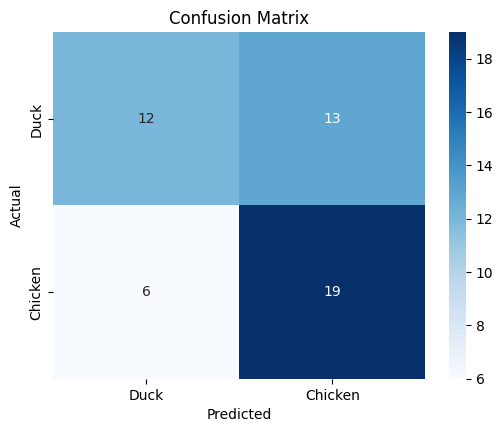

In [18]:
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 4.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Duck', 'Chicken'], yticklabels=['Duck', 'Chicken'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The model is doing almost random guessing at this point.

### Training the model

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [20]:
num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

Epoch [1/4], Loss: 0.5514
Epoch [2/4], Loss: 0.1868
Epoch [3/4], Loss: 0.0872
Epoch [4/4], Loss: 0.0447


In [21]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9800


After training, we got an accuracy of around 98%.

### Classification Report

In [22]:
predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.96      1.00      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



### Confusion Matrix

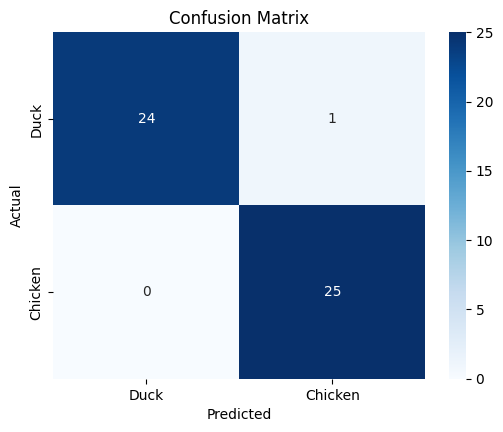

In [23]:
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 4.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Duck', 'Chicken'], yticklabels=['Duck', 'Chicken'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

From the confusion matrix, it seems that the model made very few mistakes in classification (just 1 in this case).